# Soft Actor Critic

In [1]:
import copy
import collections
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal # 정규분포 샘플링

import gymnasium as gym

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import tqdm

In [2]:
# Replay buffer, Off-Policy: 다른 정책이 수집한 데이터를 기반으로 학습을 통해 정책 강화
class ReplayBuffer():
    def __init__(self, maxlen=100000):
        self.buffer = collections.deque(maxlen=maxlen)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n=128):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(np.array(s_lst), dtype=torch.float), \
               torch.tensor(np.array(a_lst), dtype=torch.float), \
               torch.tensor(np.array(r_lst), dtype=torch.float), \
               torch.tensor(np.array(s_prime_lst), dtype=torch.float), \
               torch.tensor(np.array(done_mask_lst), dtype=torch.float)

    def size(self):
        return len(self.buffer)

In [3]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()

        self.std_min = -20
        self.std_max = 2

        # set the hidden layers
        self.hidden1 = nn.Linear(3, 128)
        self.hidden2 = nn.Linear(128, 128)

        # set log_std layer
        self.log_std_layer = nn.Linear(128, 1)

        # set mean layer
        self.mu_layer = nn.Linear(128, 1)

    def forward(self, state):
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))

        # get mean
        mu = self.mu_layer(x).tanh()

        # get std
        log_std = self.log_std_layer(x).tanh()
        log_std = self.std_min + 0.5 * (self.std_max - self.std_min) * (log_std + 1)
        std = torch.exp(log_std)

        # sample actions
        dist = Normal(mu, std)
        z = dist.rsample()

        # normalize action and log_prob
        action = z.tanh()
        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-7)
        log_prob = log_prob.sum(-1, keepdim=True)

        return action, log_prob

In [4]:
# CriticQ: 액션가치함수, 상태 s에서 액션을 선택하여 기대되는 Return 예측
class CriticQ(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden1 = nn.Linear(3 + 1, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

In [5]:
# CriticV: 상태가치함수, 현재 상태가 얻을 Return 예측
class CriticV(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden1 = nn.Linear(3, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

    def forward(self, state):
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

In [6]:
# 액션 space가 [-1, 1] 사이가 아닌 경우 필요
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

In [7]:
class SAC:
    def __init__(self):
        self.tau = 5e-3

        # automatic entropy tuning
        self.target_entropy = -1
        self.log_alpha = torch.zeros(1, requires_grad=True)

        # actor
        self.actor = Actor()
        # v function: 상태가치함수
        self.critic_v = CriticV() # Behavior
        self.critic_v_target = CriticV() # Target
        self.critic_v_target.load_state_dict(self.critic_v.state_dict())
        # q function: 액션가치함수
        self.critic_q1 = CriticQ()
        self.critic_q2 = CriticQ()

    def select_action(self, state):
        selected_action = self.actor(torch.from_numpy(state).float())[0].detach().cpu().numpy()
        return selected_action

    def soft_update(self):
        for t_param, l_param in zip(self.critic_v_target.parameters(), self.critic_v.parameters()):
            t_param.data.copy_(self.tau * l_param.data + (1.0 - self.tau) * t_param.data)

In [8]:
sac = SAC()
memory = ReplayBuffer()

In [9]:
OptimDic = collections.namedtuple('OptimDic', ['alpha_optim',
                                               'actor_optim',
                                               'critic_q1_optim',
                                               'critic_q2_optim',
                                               'critic_v_optim'])

optim_dic = OptimDic(optim.Adam([sac.log_alpha], lr=3e-4),
                     optim.Adam(sac.actor.parameters(), lr=3e-4),
                     optim.Adam(sac.critic_q1.parameters(), lr=3e-4),
                     optim.Adam(sac.critic_q2.parameters(), lr=3e-4),
                     optim.Adam(sac.critic_v.parameters(), lr=3e-4))

In [10]:
def train(sac, memory, optim_dic, gamma=0.99, train_actor=False):
    state, action, reward, next_state, done_mask = memory.sample()
    new_action, log_prob = sac.actor(state)

    # Loss Function을 이용, 예측하는 값과의 차이 줄어들도록
    # train alpha (dual problem)
    alpha_loss = (-sac.log_alpha.exp() * (log_prob + sac.target_entropy).detach()).mean()
    optim_dic.alpha_optim.zero_grad()
    alpha_loss.backward()
    optim_dic.alpha_optim.step()

    alpha = sac.log_alpha.exp()  # used for the actor loss calculation

    # q function loss
    q1_pred = sac.critic_q1(state, action)
    q2_pred = sac.critic_q2(state, action)
    v_target = sac.critic_v_target(next_state)
    q_target = reward + gamma * v_target * done_mask
    q1_loss = F.mse_loss(q1_pred, q_target.detach())
    q2_loss = F.mse_loss(q2_pred, q_target.detach())

    # v function loss
    v_pred = sac.critic_v(state)
    q_pred = torch.min(sac.critic_q1(state, new_action), sac.critic_q2(state, new_action))
    v_target = q_pred - alpha * log_prob
    v_loss = F.mse_loss(v_pred, v_target.detach())

    if train_actor:
        # actor loss
        advantage = q_pred - v_pred.detach()
        actor_loss = (alpha * log_prob - advantage).mean()

        # train actor
        optim_dic.actor_optim.zero_grad()
        actor_loss.backward()
        optim_dic.actor_optim.step()

        # target update
        sac.soft_update()

    # train Q
    optim_dic.critic_q1_optim.zero_grad()
    q1_loss.backward()
    optim_dic.critic_q1_optim.step()

    optim_dic.critic_q2_optim.zero_grad()
    q2_loss.backward()
    optim_dic.critic_q2_optim.step()

    # train V
    optim_dic.critic_v_optim.zero_grad()
    v_loss.backward()
    optim_dic.critic_v_optim.step()

In [11]:
score = 0
max_score = -99999999

env = gym.make("Pendulum-v1", render_mode="rgb_array")
env = ActionNormalizer(env)
s, _ = env.reset()

p_bar = tqdm.trange(50000)
for i in p_bar:
    if i < 9999: # 일정 주기 랜덤 샘플
        a = env.action_space.sample()
    else:
        a = sac.select_action(s)
    s_prime, r, done, oob, _ = env.step(a)
    done_mask = 0.0 if (done or oob) else 1.0
    memory.put((s, a, r/100.0, s_prime, done_mask))

    s = s_prime
    score += r

    if done or oob:
        s, _ = env.reset()
        p_bar.set_description(f'max: {max_score:.5f}, curr: {score:5f}')
        if score >= max_score: # 성능 개선이 있었으면
            torch.save(sac.actor.state_dict(), 'sac_actor.pth')
            max_score = score
        score = 0.0

    if i >= 9999:
        train(sac, memory, optim_dic, train_actor=(i % 3 == 0))

p_bar.close()
env.close()


ax: -0.16160, curr: -235.961543: 100%|█████████████████████████████████████████| 50000/50000 [03:17<00:00, 253.51it/s]

In [12]:
sac = SAC()
sac.actor.load_state_dict(torch.load('sac_actor.pth'))

<All keys matched successfully>

-121.5875835976862


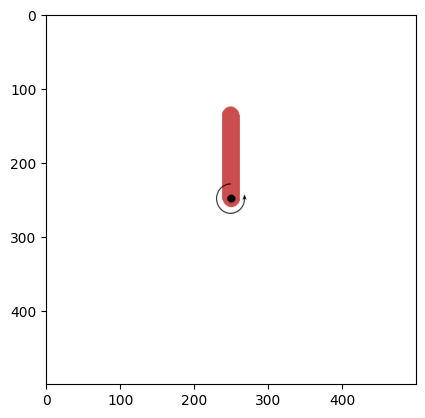

In [13]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")
env = ActionNormalizer(env)

s, _ = env.reset()
img = plt.imshow(env.render())

score = 0.0
while True:
    # display
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    a = sac.select_action(s)  # noise 없음
    s_prime, r, done, oob, info = env.step(a)
    s = s_prime
    
    score += r
    if done or oob:
        break

env.close()
print(score)